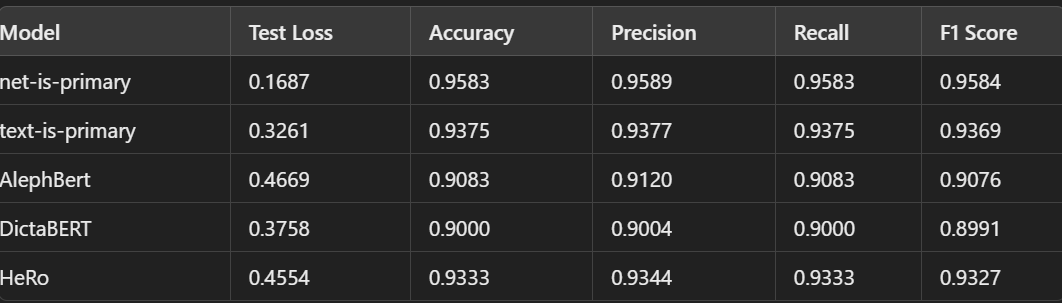

# Organized Pipeline  - Tweet

hey so this notebook will walk throgh the experiment stages:

can we identify and classify tweets as anti-vax more accuratly by adding user community signals

- setup
- data loading + pre process
- baseline models (AutoML) + llm models
- multimodal model  - text is primary
- multimodal model  - net is primary




## Setup

In [1]:
cd /sise/Yalla_work/data/from_omer_to_hila/

/sise/Yalla_work/data/from_omer_to_hila


In [2]:
# ls

In [3]:
import pandas as pd

# Read the train and test TSV files
train_df = pd.read_csv('train_tweet.tsv', sep='\t')
test_df = pd.read_csv('test_tweets.tsv', sep='\t')

# Combine the DataFrames
combined_df = pd.concat([train_df, test_df], ignore_index=True)

combined_df


,Unnamed: 0.1,Unnamed: 0,uid,handle,text,label,tweetlabel,weights,doubt
0,3451,996112,1.213563e+18,UsBnnxVURfS4lPJ,לא יפה לך להתבטא כ בצורה כזאת הבחור ענה לך ל...,0,0,0.004167,NaN
1,1410,90191,8.107499e+07,octapoos,"בנט הוא התלמיד של נתניהו, הוא למד ממנו הכול,...",0,0,0.006944,NaN
2,2620,520931,1.401969e+18,oHbGjGwwqOTi9VP,בנט לא פונקציה לידו ביבי מנהיג ברמה עולמית לא...,1,0,0.009434,NaN
3,2929,398402,2.860564e+08,arielhaham,מה יש לשתף חתיכת אפס מאופס אתם אות קלון אתם ב...,1,0,0.003344,NaN
4,2109,404294,3.303461e+08,lonvemeland,מה קרהה פתאום אין קורונה לא? למה מאריכים את ה...,1,2,0.010417,NaN
...,...,...,...,...,...,...,...,...,...
3993,3675,1013961,4.184635e+09,hairhair10,חשוד ערבי מול טרוריסט יהודי. איש קטן מספיק עם...,0,0,0.083333,NaN
3994,2813,212234,4.455603e+07,Lola_van_horn,תפתחי חבילת ספגטי.... הכי פחות מזיק כלכלית לש...,1,0,0.000136,NaN
3995,1889,82371,1.032161e+18,eliezer04341994,"הכל זה רעשי רקע , נתניהו מצליח בכלכלה במדיניות...",0,0,0.045455,1
3996,238,24203,1.503508e+08,aton_everet,"הותק של החיסון, במובן שזה חיסון שרץ משנות ה...",1,1,0.000820,NaN


## Data

/tmp/ipykernel_1923910/2452573637.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_filtered_df.dropna(subset=['text'], inplace=True)
/tmp/ipykernel_1923910/2452573637.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_filtered_df.drop_duplicates(subset=['text'], inplace=True)
/tmp/ipykernel_1923910/2452573637.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
from collections import Counter
import string
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

# Ensure you have the stopwords downloaded
nltk.download('stopwords')
hebrew_stopwords = list(stopwords.words('hebrew'))



# Remove stop words
tweets_filtered_df['clean_text'] = tweets_filtered_df['clean_text'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in hebrew_stopwords])
)

# 1. Tweet Label Distribution
tweet_label_distribution = tweets_filtered_df['tweetlabel'].value_counts()
plt.figure(figsize=(10, 6))
tweet_label_distribution.plot(kind='bar')
plt.title('Distribution of Tweet Labels')
plt.xlabel('Tweet Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# 2. User Engagement Analysis
user_engagement = tweets_filtered_df['uid'].value_counts()
top_20_users = user_engagement.head(20)
plt.figure(figsize=(12, 8))
top_20_users.plot(kind='bar')
plt.title('Top 20 Most Active Users')
plt.xlabel('User ID')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=90)
plt.show()

# 3. Text Length Analysis
tweets_filtered_df['text_length'] = tweets_filtered_df['clean_text'].apply(len)
plt.figure(figsize=(12, 6))
tweets_filtered_df['text_length'].hist(bins=50)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

average_length_by_label = tweets_filtered_df.groupby('tweetlabel')['text_length'].mean()
plt.figure(figsize=(10, 6))
average_length_by_label.plot(kind='bar')
plt.title('Average Tweet Length by Tweet Label')
plt.xlabel('Tweet Label')
plt.ylabel('Average Tweet Length')
plt.xticks(rotation=0)
plt.show()

# 4. Frequent Words/Phrases per Label
def generate_word_cloud(text, label, font_path):
    wordcloud = WordCloud(width=1600, height=800, background_color='white', font_path=font_path,
                          relative_scaling=0.5, max_font_size=200, min_font_size=10).generate(' '.join(text))
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Label {label}', fontsize=20)
    plt.axis('off')
    plt.show()

# Specify the path to the Hebrew font file
font_path = '/content/drive/MyDrive/research_covid/tweets/FreeSansBold.ttf'  # Update this to the correct path

labels = tweets_filtered_df['tweetlabel'].unique()
for label in labels:
    text_by_label = tweets_filtered_df[tweets_filtered_df['tweetlabel'] == label]['clean_text']
    generate_word_cloud(text_by_label, label, font_path)

# 5. Label Correlation
label_correlation = tweets_filtered_df[['tweetlabel', 'text_length']].corr()
plt.figure(figsize=(8, 6))
plt.matshow(label_correlation, cmap='coolwarm', fignum=1)
plt.colorbar()
plt.title('Correlation Matrix', pad=20)
plt.xticks(range(len(label_correlation.columns)), label_correlation.columns, rotation=45)
plt.yticks(range(len(label_correlation.columns)), label_correlation.columns)
plt.show()

# Sentiment Analysis
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

tweets_filtered_df['sentiment'] = tweets_filtered_df['clean_text'].apply(get_sentiment)

sentiment_distribution = tweets_filtered_df['sentiment'].value_counts()
plt.figure(figsize=(10, 6))
sentiment_distribution.plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Topic Modeling
vectorizer = CountVectorizer(stop_words=hebrew_stopwords, max_features=1000)
text_vectorized = vectorizer.fit_transform(tweets_filtered_df['clean_text'].astype(str))

lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda_model.fit_transform(text_vectorized)

def get_topic_words(model, feature_names, n_top_words):
    topic_words = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_words[topic_idx] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    return topic_words

n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
topic_words = get_topic_words(lda_model, feature_names, n_top_words)
print("Top words per topic:")
for topic, words in topic_words.items():
    print(f"Topic {topic}: {', '.join(words)}")

# Hashtag Analysis
def extract_hashtags(text):
    return re.findall(r'#\w+', text)

tweets_filtered_df['hashtags'] = tweets_filtered_df['text'].apply(extract_hashtags)
all_hashtags = [hashtag for sublist in tweets_filtered_df['hashtags'] for hashtag in sublist]
hashtag_counts = Counter(all_hashtags)

# Correct Hebrew hashtag order
def reverse_hebrew(text):
    return ' '.join(word[::-1] for word in text.split())

hashtags_df = pd.DataFrame(hashtag_counts.items(), columns=['Hashtag', 'Count'])
hashtags_df['Hashtag'] = hashtags_df['Hashtag'].apply(reverse_hebrew)
most_common_hashtags = hashtags_df.sort_values(by='Count', ascending=False).head(20)

plt.figure(figsize=(12, 8))
most_common_hashtags.plot(kind='bar', x='Hashtag', y='Count', legend=False)
plt.title('Top 20 Most Common Hashtags')
plt.xlabel('Hashtag')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


ModuleNotFoundError: No module named 'matplotlib'

## Baseline

- 3996 tweets


### AutoML

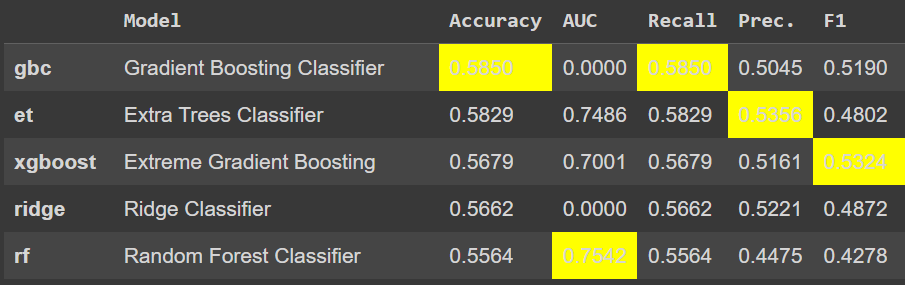

In [ ]:
# Import necessary libraries
import pandas as pd
from pycaret.classification import setup, compare_models, evaluate_model
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob

# Ensure you have the stopwords downloaded
nltk.download('stopwords')

# Assuming combined_df is already defined and loaded with the data

# Filter the dataframe to only include the columns of interest
tweets_filtered_df = combined_df[['text', 'tweetlabel']]

# Pre-processing steps
tweets_filtered_df.dropna(subset=['text'], inplace=True)
tweets_filtered_df.drop_duplicates(subset=['text'], inplace=True)

# Function to clean tweet text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces and strip text
    return text

# Apply text cleaning
tweets_filtered_df['clean_text'] = tweets_filtered_df['text'].apply(clean_text)

# Remove stop words
hebrew_stopwords = set(stopwords.words('hebrew'))
tweets_filtered_df['clean_text'] = tweets_filtered_df['clean_text'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in hebrew_stopwords])
)

# Feature Engineering
tweets_filtered_df['text_length'] = tweets_filtered_df['clean_text'].apply(len)
tweets_filtered_df['num_punctuations'] = tweets_filtered_df['clean_text'].apply(
    lambda x: len([char for char in x if char in string.punctuation])
)
tweets_filtered_df['num_stopwords'] = tweets_filtered_df['clean_text'].apply(
    lambda x: len([word for word in x.split() if word in hebrew_stopwords])
)
tweets_filtered_df['avg_word_length'] = tweets_filtered_df['clean_text'].apply(
    lambda x: sum(len(word) for word in x.split()) / len(x.split()) if len(x.split()) > 0 else 0
)
tweets_filtered_df['num_unique_words'] = tweets_filtered_df['clean_text'].apply(
    lambda x: len(set(x.split()))
)
tweets_filtered_df['sentiment_polarity'] = tweets_filtered_df['clean_text'].apply(
    lambda x: TextBlob(x).sentiment.polarity
)
tweets_filtered_df['sentiment_subjectivity'] = tweets_filtered_df['clean_text'].apply(
    lambda x: TextBlob(x).sentiment.subjectivity
)

# Vectorize the text data
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(tweets_filtered_df['clean_text']).toarray()

# Convert to DataFrame
X_df = pd.DataFrame(X, columns=vectorizer.get_feature_names_out())

# Add engineered features to the DataFrame
X_df['text_length'] = tweets_filtered_df['text_length'].values
X_df['num_punctuations'] = tweets_filtered_df['num_punctuations'].values
X_df['num_stopwords'] = tweets_filtered_df['num_stopwords'].values
X_df['avg_word_length'] = tweets_filtered_df['avg_word_length'].values
X_df['num_unique_words'] = tweets_filtered_df['num_unique_words'].values
X_df['sentiment_polarity'] = tweets_filtered_df['sentiment_polarity'].values
X_df['sentiment_subjectivity'] = tweets_filtered_df['sentiment_subjectivity'].values

# Add the target variable to the DataFrame
X_df['tweetlabel'] = tweets_filtered_df['tweetlabel'].values

# Combine the features and target variable into a single DataFrame, avoiding duplication
dataset = X_df.copy()  # Start with the features
if 'tweetlabel' not in dataset.columns:  # Check if 'tweetlabel' is already present
    dataset['tweetlabel'] = tweets_filtered_df['tweetlabel'].values  # Add it if not

# Initialize PyCaret setup
clf = setup(data=dataset, target='tweetlabel', session_id=42)

# Compare models
best_model = compare_models()

# Evaluate the best model
evaluate_model(best_model)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Description,Value
0,Session id,42
1,Target,tweetlabel
2,Target type,Multiclass
3,Original data shape,"(597, 6038)"
4,Transformed data shape,"(597, 6038)"
5,Transformed train set shape,"(417, 6038)"
6,Transformed test set shape,"(180, 6038)"
7,Numeric features,6037
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.5850,0.0000,0.5850,0.5045,0.5190,0.2288,0.2559,2.0930
et,Extra Trees Classifier,0.5829,0.7486,0.5829,0.5356,0.4802,0.1638,0.2453,0.5410
xgboost,Extreme Gradient Boosting,0.5679,0.7001,0.5679,0.5161,0.5324,0.2437,0.2526,2.6400
ridge,Ridge Classifier,0.5662,0.0000,0.5662,0.5221,0.4872,0.1737,0.2125,0.4430
rf,Random Forest Classifier,0.5564,0.7542,0.5564,0.4475,0.4278,0.0885,0.1663,0.5070
dt,Decision Tree Classifier,0.5467,0.6209,0.5467,0.5256,0.5285,0.2280,0.2327,0.3960
lr,Logistic Regression,0.5445,0.0000,0.5445,0.4907,0.4527,0.1147,0.1552,2.7740
lightgbm,Light Gradient Boosting Machine,0.5367,0.6835,0.5367,0.5144,0.5177,0.2127,0.2188,192.1720
ada,Ada Boost Classifier,0.5322,0.0000,0.5322,0.4610,0.4770,0.1553,0.1718,0.5860
dummy,Dummy Classifier,0.5276,0.5000,0.5276,0.2784,0.3645,0.0000,0.0000,0.7670


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### LLM - AlephBert,  DictaBert ,HeRo

{'AlephBert': {'best_params': {'learning_rate': 2.792447818056219e-05,
   'num_train_epochs': 6,
   'per_device_train_batch_size': 8,
   'weight_decay': 0.010203877055472191},
  'best_accuracy': 0.7625,
  'best_metrics': {'loss': 0.548204779624939,
   'accuracy': 0.7625,
   'f1': 0.765731483804489,
   'precision': 0.7726881255988419,
   'recall': 0.7625,
   'runtime': 0.7251,
   'samples_per_second': 551.625,
   'steps_per_second': 34.477}},

   
 'DictaBERT': {'best_params': {'learning_rate': 4.874726423319144e-05,
   'num_train_epochs': 8,
   'per_device_train_batch_size': 32,
   'weight_decay': 0.034801759240069605},
  'best_accuracy': 0.8,
  'best_metrics': {'loss': 0.759141743183136,
   'accuracy': 0.8,
   'f1': 0.8045241392287239,
   'precision': 0.8242124332570556,
   'recall': 0.8,
   'runtime': 0.7265,
   'samples_per_second': 550.559,
   'steps_per_second': 34.41}},

   
 'HeRo': {'best_params': {'learning_rate': 2.365006575662619e-05,
   'num_train_epochs': 9,
   'per_device_train_batch_size': 16,
   'weight_decay': 0.011233976779149231},
  'best_accuracy': 0.78,
  'best_metrics': {'loss': 0.6959271430969238,
   'accuracy': 0.78,
   'f1': 0.7879155193683691,
   'precision': 0.8044428990641947,
   'recall': 0.78,
   'runtime': 0.7055,
   'samples_per_second': 566.965,
   'steps_per_second': 35.435}}}

In [4]:
cd ../../../

/sise


In [5]:
cd ../home/hillahlv

/sise/home/hillahlv


In [6]:
cd scripts/covid_project/

/sise/home/hillahlv/scripts/covid_project


In [3]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# Ensure you have the stopwords downloaded
nltk.download('stopwords')
hebrew_stopwords = set(stopwords.words('hebrew'))

# Function to clean tweet text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces and strip text
    text = ' '.join([word for word in text.split() if word not in hebrew_stopwords])  # Remove stop words
    return text

# Load your DataFrame
# Ensure 'combined_df' is defined. For example:
# combined_df = pd.read_csv('path_to_your_csv_file.csv')

# Filter the dataframe to only include the columns of interest
tweets_filtered_df = combined_df[['text', 'tweetlabel']]

tweets_filtered_df= tweets_filtered_df.dropna()


# Apply text cleaning
tweets_filtered_df['clean_text'] = tweets_filtered_df['text'].apply(clean_text)



/home/hillahlv/.conda/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hillahlv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import optuna
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import torch

# Ensure clean_text column contains strings
tweets_filtered_df['clean_text'] = tweets_filtered_df['clean_text'].astype(str)

# Create a Hugging Face dataset
dataset = Dataset.from_pandas(tweets_filtered_df[['clean_text', 'tweetlabel']])
# Split the dataset into training, validation, and testing sets
dataset = dataset.train_test_split(test_size=0.2, seed=42)
test_valid = dataset['test'].train_test_split(test_size=0.5, seed=42)
dataset = DatasetDict({
    'train': dataset['train'],
    'validation': test_valid['train'],
    'test': test_valid['test']
})

# Define the model names
model_names = {
    'AlephBert': 'onlplab/alephbert-base',
    'DictaBERT': 'dicta-il/dictabert',
    'HeRo': 'HeNLP/HeRo'
}

# Function to compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# Function to fine-tune and evaluate a model
def fine_tune_and_evaluate(trial, model_name, model_path):
    # Load the tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=3)

    # Tokenize the dataset
    def preprocess_function(examples):
        return tokenizer(examples['clean_text'], truncation=True, padding='max_length', max_length=128)

    tokenized_datasets = dataset.map(preprocess_function, batched=True)

    # Align label names with model output
    tokenized_datasets = tokenized_datasets.rename_column("tweetlabel", "labels")
    tokenized_datasets.set_format("torch")

    # Suggest hyperparameters for tuning
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
    num_train_epochs = trial.suggest_int('num_train_epochs', 3, 10)
    per_device_train_batch_size = trial.suggest_categorical('per_device_train_batch_size', [8, 16, 32])
    weight_decay = trial.suggest_loguniform('weight_decay', 0.01, 0.1)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f'./tweet_classifiers/{model_name}',
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=16,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        logging_dir=f'./tweet_classifiers/logs/{model_name}',
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model="eval_accuracy",
        save_strategy="epoch",
        gradient_accumulation_steps=2,
        lr_scheduler_type='linear'
    )

    early_stopping = EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)

    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['validation'],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping]
    )

    # Train and evaluate the model
    trainer.train()
    eval_results = trainer.evaluate(tokenized_datasets['validation'])
    accuracy = eval_results['eval_accuracy']
    metrics = {k.replace('eval_', ''): v for k, v in eval_results.items() if k.startswith('eval_')}

    # Save the best model
    best_model_path = f'./tweet_classifiers/best_models/{model_name}'
    model.save_pretrained(best_model_path)
    tokenizer.save_pretrained(best_model_path)

    return accuracy, metrics

# Optuna objective function for each model
def objective_for_model(model_name, model_path):
    def objective(trial):
        return fine_tune_and_evaluate(trial, model_name, model_path)[0]
    return objective

# Optimize each model separately
best_results = {}
for model_name, model_path in model_names.items():
    print(f"Optimizing {model_name}...")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_for_model(model_name, model_path), n_trials=20)
    best_accuracy, best_metrics = fine_tune_and_evaluate(study.best_trial, model_name, model_path)
    best_results[model_name] = {
        'best_params': study.best_params,
        'best_accuracy': best_accuracy,
        'best_metrics': best_metrics
    }
    print(f"Best hyperparameters for {model_name}: {study.best_params}")
    print(f"Best accuracy for {model_name}: {best_accuracy}")
    print(f"Best metrics for {model_name}: {best_metrics}")

print("Best results for each model:")
print(best_results)


[I 2024-07-30 18:43:15,373] A new study created in memory with name: no-name-d802c071-285b-401b-83b3-94d895dc922f


Optimizing AlephBert...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 10804.88 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
/tmp/ipykernel_2699570/1147506628.py:58: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = tr

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,0.604695,0.707447,0.670288,0.741724,0.707447
2,No log,0.622594,0.750000,0.740374,0.741992,0.750000
4,No log,0.768897,0.750000,0.744725,0.745298,0.750000


[I 2024-07-30 18:45:52,109] Trial 0 finished with value: 0.7872340425531915 and parameters: {'learning_rate': 3.4328773781069994e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 32, 'weight_decay': 0.06434719337104745}. Best is trial 0 with value: 0.7872340425531915.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 10264.50 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate',

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.553629,0.776596,0.773046,0.794207,0.776596
2,No log,0.524836,0.803191,0.804652,0.808540,0.803191
3,No log,0.543893,0.787234,0.786476,0.788772,0.787234


[I 2024-07-30 18:47:16,402] Trial 1 finished with value: 0.8031914893617021 and parameters: {'learning_rate': 4.3350542057343635e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.07941672831279696}. Best is trial 1 with value: 0.8031914893617021.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 10698.30 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate',

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,0.723819,0.643617,0.614996,0.621261,0.643617
2,No log,0.556514,0.803191,0.802069,0.801198,0.803191
4,No log,0.596084,0.765957,0.764067,0.762660,0.765957
6,No log,0.627774,0.765957,0.763541,0.764142,0.765957


[I 2024-07-30 18:49:48,496] Trial 2 finished with value: 0.8031914893617021 and parameters: {'learning_rate': 1.8113399490282713e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 32, 'weight_decay': 0.06274058544241796}. Best is trial 1 with value: 0.8031914893617021.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 10620.35 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate',

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.706021,0.702128,0.685648,0.698798,0.702128
2,No log,0.601423,0.755319,0.754391,0.753962,0.755319
3,No log,0.578490,0.760638,0.755034,0.753698,0.760638
4,No log,0.580504,0.803191,0.804319,0.805951,0.803191
5,No log,0.581144,0.781915,0.779400,0.777612,0.781915
6,No log,0.586659,0.787234,0.785380,0.783944,0.787234


[I 2024-07-30 18:52:26,452] Trial 3 finished with value: 0.8031914893617021 and parameters: {'learning_rate': 1.0044487618441248e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 16, 'weight_decay': 0.06918961610365201}. Best is trial 1 with value: 0.8031914893617021.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 10922.97 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate',

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.605639,0.707447,0.673918,0.775115,0.707447
2,No log,0.533601,0.787234,0.789840,0.793306,0.787234
3,No log,0.571040,0.771277,0.767951,0.768395,0.771277
4,No log,0.592121,0.750000,0.747902,0.747144,0.750000


[I 2024-07-30 18:54:14,521] Trial 4 finished with value: 0.7872340425531915 and parameters: {'learning_rate': 2.789301017652144e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.05928216681256841}. Best is trial 1 with value: 0.8031914893617021.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 10773.14 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,0.604976,0.707447,0.648389,0.820150,0.707447
2,No log,0.673321,0.744681,0.740238,0.739193,0.744681
4,No log,0.851598,0.755319,0.750860,0.751279,0.755319


[I 2024-07-30 18:56:22,461] Trial 5 finished with value: 0.7925531914893617 and parameters: {'learning_rate': 4.9871386052879074e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 32, 'weight_decay': 0.04581530290732487}. Best is trial 1 with value: 0.8031914893617021.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 10554.82 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate',

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,0.736214,0.680851,0.659006,0.663906,0.680851
2,No log,0.546149,0.787234,0.785467,0.784961,0.787234
4,No log,0.536953,0.765957,0.763330,0.761608,0.765957
5,No log,0.538006,0.781915,0.780001,0.778504,0.781915


[I 2024-07-30 18:59:07,267] Trial 6 finished with value: 0.7978723404255319 and parameters: {'learning_rate': 1.6485882606158493e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 32, 'weight_decay': 0.08179844924933723}. Best is trial 1 with value: 0.8031914893617021.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 10705.71 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate',

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.576335,0.728723,0.695312,0.773555,0.728723
2,No log,0.543911,0.744681,0.732245,0.755837,0.744681
3,No log,0.577220,0.771277,0.770611,0.785078,0.771277
4,No log,0.673708,0.771277,0.766894,0.773667,0.771277
5,No log,0.683160,0.787234,0.786234,0.786046,0.787234


[I 2024-07-30 19:01:36,096] Trial 7 finished with value: 0.7872340425531915 and parameters: {'learning_rate': 1.8231395658403124e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.07552832861081002}. Best is trial 1 with value: 0.8031914893617021.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 10603.50 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.565433,0.734043,0.707843,0.780669,0.734043
2,No log,0.529906,0.744681,0.733503,0.765766,0.744681
3,No log,0.549948,0.781915,0.780316,0.793440,0.781915
4,No log,0.612720,0.787234,0.784380,0.792328,0.787234
5,No log,0.644592,0.771277,0.769448,0.768158,0.771277


[I 2024-07-30 19:04:03,031] Trial 8 finished with value: 0.7872340425531915 and parameters: {'learning_rate': 1.7083145126445687e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.014127232930643415}. Best is trial 1 with value: 0.8031914893617021.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 10511.76 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate',

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.561090,0.728723,0.696299,0.776438,0.728723
2,No log,0.523686,0.750000,0.740819,0.767321,0.750000
3,No log,0.544707,0.776596,0.773319,0.787474,0.776596
4,No log,0.562248,0.792553,0.791977,0.791462,0.792553


[I 2024-07-30 19:06:04,463] Trial 9 finished with value: 0.7925531914893617 and parameters: {'learning_rate': 1.9306110110960725e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 8, 'weight_decay': 0.09834065970953859}. Best is trial 1 with value: 0.8031914893617021.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 10518.21 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.528206,0.771277,0.763975,0.775917,0.771277
2,No log,0.516927,0.808511,0.809533,0.811000,0.808511
3,No log,0.769621,0.792553,0.792894,0.794486,0.792553
4,No log,1.144255,0.803191,0.795822,0.821980,0.803191
5,No log,1.079999,0.797872,0.797872,0.810271,0.797872


[I 2024-07-30 19:08:15,610] Trial 10 finished with value: 0.8085106382978723 and parameters: {'learning_rate': 4.4206010495054976e-05, 'num_train_epochs': 10, 'per_device_train_batch_size': 16, 'weight_decay': 0.023255370241918278}. Best is trial 10 with value: 0.8085106382978723.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 10574.49 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_ra

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.537504,0.750000,0.739200,0.762667,0.750000
2,No log,0.532655,0.808511,0.809088,0.809727,0.808511
3,No log,0.773376,0.739362,0.732549,0.733116,0.739362
4,No log,1.134583,0.760638,0.747837,0.814317,0.760638
5,No log,1.089619,0.771277,0.770168,0.777498,0.771277


[I 2024-07-30 19:10:27,108] Trial 11 finished with value: 0.8085106382978723 and parameters: {'learning_rate': 4.6631544803938726e-05, 'num_train_epochs': 10, 'per_device_train_batch_size': 16, 'weight_decay': 0.022021338943278814}. Best is trial 10 with value: 0.8085106382978723.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 10670.65 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_ra

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.555711,0.771277,0.767403,0.790254,0.771277
2,No log,0.559291,0.750000,0.739566,0.758196,0.750000
3,No log,0.662049,0.792553,0.789665,0.821217,0.792553
4,No log,0.813096,0.771277,0.766840,0.768695,0.771277
5,No log,0.992715,0.781915,0.778637,0.780777,0.781915
6,No log,1.060778,0.760638,0.762028,0.763600,0.760638


[I 2024-07-30 19:13:04,731] Trial 12 finished with value: 0.7925531914893617 and parameters: {'learning_rate': 3.551430061580008e-05, 'num_train_epochs': 10, 'per_device_train_batch_size': 16, 'weight_decay': 0.02127209534430832}. Best is trial 10 with value: 0.8085106382978723.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 10033.96 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.605263,0.712766,0.679012,0.782194,0.712766
2,No log,0.530006,0.803191,0.804869,0.807010,0.803191
3,No log,0.661275,0.739362,0.735762,0.764190,0.739362
4,No log,0.746840,0.781915,0.780116,0.780889,0.781915
5,No log,0.819571,0.792553,0.793643,0.794976,0.792553


[I 2024-07-30 19:15:17,365] Trial 13 finished with value: 0.8031914893617021 and parameters: {'learning_rate': 2.6372263703562812e-05, 'num_train_epochs': 10, 'per_device_train_batch_size': 16, 'weight_decay': 0.02695898271523491}. Best is trial 10 with value: 0.8085106382978723.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 10723.47 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rat

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.547678,0.765957,0.761937,0.778948,0.765957
2,No log,0.548932,0.792553,0.789822,0.790116,0.792553
3,No log,0.671513,0.792553,0.788750,0.818443,0.792553
4,No log,0.836475,0.771277,0.766361,0.767736,0.771277
5,No log,0.957951,0.776596,0.777802,0.779245,0.776596


[I 2024-07-30 19:17:28,755] Trial 14 finished with value: 0.7925531914893617 and parameters: {'learning_rate': 3.9099294510186434e-05, 'num_train_epochs': 9, 'per_device_train_batch_size': 16, 'weight_decay': 0.01577218157092606}. Best is trial 10 with value: 0.8085106382978723.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 10905.14 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.539747,0.750000,0.736787,0.760126,0.750000
2,No log,0.532177,0.808511,0.809792,0.811265,0.808511
3,No log,0.764329,0.760638,0.756571,0.755027,0.760638
4,No log,0.984402,0.765957,0.762171,0.760203,0.765957
5,No log,1.031267,0.787234,0.789867,0.794351,0.787234


[I 2024-07-30 19:19:39,683] Trial 15 finished with value: 0.8085106382978723 and parameters: {'learning_rate': 4.935420727721518e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.010403287440717869}. Best is trial 10 with value: 0.8085106382978723.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 10884.67 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.567224,0.750000,0.733016,0.793597,0.750000
2,No log,0.539960,0.744681,0.732360,0.757337,0.744681
3,No log,0.599417,0.787234,0.787836,0.809902,0.787234
4,No log,0.707169,0.797872,0.797394,0.797410,0.797872
5,No log,0.959284,0.797872,0.797385,0.817758,0.797872
6,No log,1.064721,0.760638,0.762301,0.767617,0.760638
7,No log,1.136158,0.755319,0.753674,0.755349,0.755319


[I 2024-07-30 19:22:40,053] Trial 16 finished with value: 0.7978723404255319 and parameters: {'learning_rate': 2.975458990623999e-05, 'num_train_epochs': 9, 'per_device_train_batch_size': 16, 'weight_decay': 0.03595029319882149}. Best is trial 10 with value: 0.8085106382978723.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 10557.92 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate'

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.649021,0.696809,0.652182,0.730881,0.696809
2,No log,0.566911,0.755319,0.756791,0.759537,0.755319
3,No log,0.568442,0.776596,0.773391,0.780084,0.776596
4,No log,0.611880,0.739362,0.736078,0.758142,0.739362
5,No log,0.635403,0.755319,0.756016,0.756778,0.755319
6,No log,0.754108,0.739362,0.739344,0.739390,0.739362


[I 2024-07-30 19:25:18,869] Trial 17 finished with value: 0.776595744680851 and parameters: {'learning_rate': 1.3174437951999386e-05, 'num_train_epochs': 10, 'per_device_train_batch_size': 16, 'weight_decay': 0.022323731856838124}. Best is trial 10 with value: 0.8085106382978723.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 10556.65 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rat

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.605296,0.707447,0.673918,0.775115,0.707447
2,No log,0.531032,0.792553,0.794392,0.796688,0.792553
3,No log,0.615152,0.760638,0.759450,0.774204,0.760638
4,No log,0.694676,0.776596,0.774765,0.785895,0.776596
5,No log,0.740927,0.792553,0.792882,0.793680,0.792553


[I 2024-07-30 19:27:31,068] Trial 18 finished with value: 0.7925531914893617 and parameters: {'learning_rate': 2.3669782634215695e-05, 'num_train_epochs': 9, 'per_device_train_batch_size': 16, 'weight_decay': 0.03421715049431462}. Best is trial 10 with value: 0.8085106382978723.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 10597.66 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.542099,0.702128,0.636992,0.730679,0.702128
2,No log,0.508616,0.776596,0.771386,0.777388,0.776596
3,No log,0.754296,0.750000,0.738065,0.750031,0.750000
4,No log,1.023829,0.792553,0.787107,0.811594,0.792553
5,No log,1.151046,0.781915,0.779446,0.785331,0.781915
6,0.292100,1.160087,0.781915,0.779534,0.781213,0.781915
7,0.292100,1.149408,0.803191,0.802053,0.801201,0.803191


[I 2024-07-30 19:30:52,991] Trial 19 finished with value: 0.8031914893617021 and parameters: {'learning_rate': 3.21917919308421e-05, 'num_train_epochs': 7, 'per_device_train_batch_size': 8, 'weight_decay': 0.01851511881377741}. Best is trial 10 with value: 0.8085106382978723.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 10679.90 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.534947,0.776596,0.768821,0.796912,0.776596
2,No log,0.528663,0.797872,0.796374,0.795815,0.797872
3,No log,0.678946,0.744681,0.740855,0.754564,0.744681
4,No log,0.885454,0.787234,0.781776,0.793856,0.787234
5,No log,1.039432,0.755319,0.759740,0.775087,0.755319


[I 2024-07-30 19:33:04,844] A new study created in memory with name: no-name-11ae1a73-f773-4ff3-9334-5c98a6572536


Best hyperparameters for AlephBert: {'learning_rate': 4.4206010495054976e-05, 'num_train_epochs': 10, 'per_device_train_batch_size': 16, 'weight_decay': 0.023255370241918278}
Best accuracy for AlephBert: 0.7978723404255319
Best metrics for AlephBert: {'loss': 0.5286629796028137, 'accuracy': 0.7978723404255319, 'f1': 0.7963742986774461, 'precision': 0.7958147677588293, 'recall': 0.7978723404255319, 'runtime': 0.8496, 'samples_per_second': 221.281, 'steps_per_second': 14.124}
Optimizing DictaBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 6992.12 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
/tmp/ipykernel_2699570/1147506628.py:58: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.s

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,0.554702,0.718085,0.696483,0.747127,0.718085
2,No log,0.501477,0.787234,0.779632,0.793622,0.787234
4,No log,0.537898,0.813830,0.812124,0.812056,0.813830
6,No log,0.601766,0.792553,0.790880,0.791063,0.792553
8,No log,0.613643,0.808511,0.808261,0.808309,0.808511


[I 2024-07-30 19:36:58,268] Trial 0 finished with value: 0.8138297872340425 and parameters: {'learning_rate': 3.629471790542309e-05, 'num_train_epochs': 9, 'per_device_train_batch_size': 32, 'weight_decay': 0.09189909532924176}. Best is trial 0 with value: 0.8138297872340425.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 7047.42 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5,

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,0.600736,0.744681,0.737317,0.738045,0.744681
2,No log,0.463961,0.819149,0.819276,0.820074,0.819149
4,No log,0.459826,0.813830,0.811750,0.810469,0.813830
5,No log,0.451957,0.813830,0.812240,0.811219,0.813830


[I 2024-07-30 19:39:47,684] Trial 1 finished with value: 0.8297872340425532 and parameters: {'learning_rate': 2.3232018368729427e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 32, 'weight_decay': 0.03559009140311516}. Best is trial 1 with value: 0.8297872340425532.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 7010.89 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,0.570431,0.765957,0.748986,0.783233,0.765957
2,No log,0.458031,0.808511,0.809923,0.812688,0.808511
4,No log,0.516403,0.781915,0.778246,0.776432,0.781915
6,No log,0.555228,0.792553,0.792034,0.792670,0.792553


[I 2024-07-30 19:42:43,376] Trial 2 finished with value: 0.8085106382978723 and parameters: {'learning_rate': 3.5511350687475233e-05, 'num_train_epochs': 9, 'per_device_train_batch_size': 32, 'weight_decay': 0.0696133377197454}. Best is trial 1 with value: 0.8297872340425532.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 7014.82 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5,

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.523184,0.702128,0.625950,0.593459,0.702128
2,No log,0.500050,0.803191,0.800811,0.812626,0.803191
3,No log,0.566244,0.776596,0.775002,0.795546,0.776596
4,No log,0.659041,0.760638,0.756119,0.775336,0.760638
5,No log,0.843491,0.776596,0.766513,0.803432,0.776596


/home/hillahlv/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[I 2024-07-30 19:45:14,016] Trial 3 finished with value: 0.8031914893617021 and parameters: {'learning_rate': 4.1093669441246646e-05, 'num_train_epochs': 9, 'per_device_train_batch_size': 16, 'weight_decay': 0.02022189581809995}. Best is trial 1 with value: 0.8297872340425532.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 6877.71 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,0.566028,0.739362,0.704757,0.744775,0.739362
2,No log,0.494302,0.776596,0.771416,0.770172,0.776596


[I 2024-07-30 19:46:44,479] Trial 4 finished with value: 0.7819148936170213 and parameters: {'learning_rate': 4.1504678253205445e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 32, 'weight_decay': 0.06298822819699806}. Best is trial 1 with value: 0.8297872340425532.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 7090.39 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,0.582466,0.723404,0.684030,0.757755,0.723404
2,No log,0.477124,0.819149,0.817948,0.817300,0.819149
4,No log,0.539424,0.803191,0.801123,0.803580,0.803191
6,No log,0.648245,0.797872,0.783912,0.830155,0.797872


[I 2024-07-30 19:49:36,232] Trial 5 finished with value: 0.8191489361702128 and parameters: {'learning_rate': 4.610541395402993e-05, 'num_train_epochs': 9, 'per_device_train_batch_size': 32, 'weight_decay': 0.05656686181019533}. Best is trial 1 with value: 0.8297872340425532.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 7060.61 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5,

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.638135,0.670213,0.588891,0.531028,0.670213
2,No log,0.474901,0.797872,0.797303,0.801706,0.797872
3,No log,0.504611,0.808511,0.810728,0.817741,0.808511
4,No log,0.709022,0.787234,0.786476,0.788772,0.787234
5,No log,0.769471,0.803191,0.800415,0.814417,0.803191


/home/hillahlv/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[I 2024-07-30 19:52:24,986] Trial 6 finished with value: 0.8085106382978723 and parameters: {'learning_rate': 4.793288512896756e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.013413671610629853}. Best is trial 1 with value: 0.8297872340425532.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 6996.52 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5,

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,0.870667,0.632979,0.575417,0.667208,0.632979
2,No log,0.534924,0.776596,0.771694,0.778600,0.776596
4,No log,0.506536,0.787234,0.783189,0.780780,0.787234
6,No log,0.496225,0.787234,0.785380,0.783944,0.787234


[I 2024-07-30 19:55:42,311] Trial 7 finished with value: 0.7925531914893617 and parameters: {'learning_rate': 1.0445222544282347e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 32, 'weight_decay': 0.018577579752816195}. Best is trial 1 with value: 0.8297872340425532.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 6976.28 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.561589,0.702128,0.621481,0.577605,0.702128
2,No log,0.493007,0.797872,0.800671,0.804986,0.797872
3,No log,0.470823,0.792553,0.793401,0.803598,0.792553
4,No log,0.577025,0.776596,0.773215,0.776407,0.776596
5,No log,0.609268,0.803191,0.801878,0.801921,0.803191


/home/hillahlv/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[I 2024-07-30 19:58:31,087] Trial 8 finished with value: 0.8031914893617021 and parameters: {'learning_rate': 1.713990741320878e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.04872924689067836}. Best is trial 1 with value: 0.8297872340425532.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 7218.72 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.619729,0.755319,0.749192,0.756228,0.755319
2,No log,0.510875,0.797872,0.794517,0.792819,0.797872
3,No log,0.477584,0.781915,0.777724,0.776481,0.781915
4,No log,0.458536,0.797872,0.800538,0.805119,0.797872
5,No log,0.461225,0.797872,0.796542,0.797206,0.797872


[I 2024-07-30 20:00:58,362] Trial 9 finished with value: 0.7978723404255319 and parameters: {'learning_rate': 1.2237154384251607e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.016055400107218756}. Best is trial 1 with value: 0.8297872340425532.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 6948.92 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.530143,0.734043,0.684888,0.785950,0.734043
2,No log,0.456161,0.787234,0.789327,0.791852,0.787234
3,No log,0.496852,0.776596,0.774359,0.786192,0.776596
4,No log,0.558091,0.776596,0.774075,0.789186,0.776596
5,No log,0.541017,0.792553,0.792317,0.794611,0.792553


[I 2024-07-30 20:03:46,763] Trial 10 finished with value: 0.7925531914893617 and parameters: {'learning_rate': 2.5017744550182712e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.034582358187523685}. Best is trial 1 with value: 0.8297872340425532.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 6577.00 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,0.625235,0.750000,0.746518,0.753627,0.750000
2,No log,0.472486,0.792553,0.793889,0.796065,0.792553
4,No log,0.462260,0.808511,0.808537,0.808636,0.808511
5,No log,0.463208,0.813830,0.813315,0.812863,0.813830


[I 2024-07-30 20:06:36,014] Trial 11 finished with value: 0.8138297872340425 and parameters: {'learning_rate': 2.397281973807186e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 32, 'weight_decay': 0.03321700557878198}. Best is trial 1 with value: 0.8297872340425532.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 6912.19 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,0.717762,0.712766,0.684137,0.734680,0.712766
2,No log,0.513574,0.765957,0.762805,0.761626,0.765957
4,No log,0.500691,0.781915,0.779474,0.778001,0.781915
5,No log,0.494705,0.781915,0.780779,0.780437,0.781915


[I 2024-07-30 20:09:25,609] Trial 12 finished with value: 0.7925531914893617 and parameters: {'learning_rate': 1.6822302641820383e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 32, 'weight_decay': 0.04583751912253248}. Best is trial 1 with value: 0.8297872340425532.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 6983.33 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,0.575461,0.781915,0.775293,0.791862,0.781915
2,No log,0.465203,0.813830,0.814361,0.814956,0.813830
4,No log,0.500362,0.792553,0.792701,0.793135,0.792553
6,No log,0.537675,0.797872,0.797298,0.799765,0.797872


[I 2024-07-30 20:12:19,516] Trial 13 finished with value: 0.8138297872340425 and parameters: {'learning_rate': 3.080308082180567e-05, 'num_train_epochs': 10, 'per_device_train_batch_size': 32, 'weight_decay': 0.024532137682222073}. Best is trial 1 with value: 0.8297872340425532.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 7031.90 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,0.747958,0.691489,0.649649,0.722353,0.691489
2,No log,0.555806,0.771277,0.767387,0.765518,0.771277


[I 2024-07-30 20:13:52,920] Trial 14 finished with value: 0.7712765957446809 and parameters: {'learning_rate': 1.6631440222279878e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 32, 'weight_decay': 0.04508151633003314}. Best is trial 1 with value: 0.8297872340425532.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 7089.18 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.553492,0.728723,0.681444,0.787353,0.728723
2,No log,0.499065,0.781915,0.776715,0.779163,0.781915
3,No log,0.472877,0.787234,0.776707,0.808320,0.787234
4,No log,0.505175,0.755319,0.750451,0.784060,0.755319
5,No log,0.484211,0.797872,0.797202,0.798755,0.797872
6,No log,0.492889,0.808511,0.808511,0.808511,0.808511
7,No log,0.509855,0.803191,0.801433,0.800967,0.803191


[I 2024-07-30 20:17:19,681] Trial 15 finished with value: 0.8085106382978723 and parameters: {'learning_rate': 2.0155374572632208e-05, 'num_train_epochs': 7, 'per_device_train_batch_size': 16, 'weight_decay': 0.010454802772725987}. Best is trial 1 with value: 0.8297872340425532.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 6916.98 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,0.573834,0.776596,0.778158,0.781565,0.776596
2,No log,0.473363,0.797872,0.797592,0.797600,0.797872
4,No log,0.463901,0.797872,0.796812,0.796001,0.797872


[I 2024-07-30 20:19:47,275] Trial 16 finished with value: 0.7978723404255319 and parameters: {'learning_rate': 2.8497764335210936e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 32, 'weight_decay': 0.09859782029329002}. Best is trial 1 with value: 0.8297872340425532.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 6972.33 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,0.545629,0.723404,0.700057,0.745413,0.723404
2,No log,0.514318,0.771277,0.754276,0.789251,0.771277
4,No log,0.534558,0.819149,0.819857,0.821373,0.819149
6,No log,0.557752,0.819149,0.818680,0.818275,0.819149


[I 2024-07-30 20:23:05,189] Trial 17 finished with value: 0.824468085106383 and parameters: {'learning_rate': 4.943968102332452e-05, 'num_train_epochs': 7, 'per_device_train_batch_size': 32, 'weight_decay': 0.026818897956453258}. Best is trial 1 with value: 0.8297872340425532.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 7018.88 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.549186,0.702128,0.621481,0.577605,0.702128
2,No log,0.497174,0.797872,0.796230,0.795874,0.797872
3,No log,0.472322,0.808511,0.810561,0.813909,0.808511
4,No log,0.518739,0.755319,0.747639,0.760423,0.755319
5,No log,0.511561,0.808511,0.807479,0.807436,0.808511
6,0.462200,0.530072,0.803191,0.802989,0.804003,0.803191


/home/hillahlv/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[I 2024-07-30 20:26:29,091] Trial 18 finished with value: 0.8085106382978723 and parameters: {'learning_rate': 1.3439714876652456e-05, 'num_train_epochs': 7, 'per_device_train_batch_size': 8, 'weight_decay': 0.026221438544577085}. Best is trial 1 with value: 0.8297872340425532.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 6918.68 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.571399,0.723404,0.668259,0.767445,0.723404
2,No log,0.515335,0.776596,0.772198,0.771388,0.776596
3,No log,0.475991,0.787234,0.786864,0.789888,0.787234
4,No log,0.470711,0.797872,0.796613,0.795634,0.797872


[I 2024-07-30 20:28:30,356] Trial 19 finished with value: 0.7978723404255319 and parameters: {'learning_rate': 1.9097438197834426e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.026783070572207798}. Best is trial 1 with value: 0.8297872340425532.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 6914.98 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,0.630728,0.755319,0.750794,0.747879,0.755319
2,No log,0.484279,0.803191,0.802630,0.802131,0.803191
4,No log,0.476240,0.813830,0.811330,0.810002,0.813830
5,No log,0.472199,0.813830,0.811330,0.810002,0.813830


[I 2024-07-30 20:31:21,018] A new study created in memory with name: no-name-6e472aa9-7a63-4332-b6d4-8dddec727c37


Best hyperparameters for DictaBERT: {'learning_rate': 2.3232018368729427e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 32, 'weight_decay': 0.03559009140311516}
Best accuracy for DictaBERT: 0.8191489361702128
Best metrics for DictaBERT: {'loss': 0.4716368317604065, 'accuracy': 0.8191489361702128, 'f1': 0.8174843396840463, 'precision': 0.816852680623977, 'recall': 0.8191489361702128, 'runtime': 0.8417, 'samples_per_second': 223.366, 'steps_per_second': 14.257}
Optimizing HeRo...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HeNLP/HeRo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 12353.97 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
/tmp/ipykernel_2699570/1147506628.py:58: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_dec

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.543369,0.718085,0.665382,0.724101,0.718085
2,No log,0.525923,0.755319,0.752769,0.750925,0.755319
3,No log,0.476867,0.808511,0.810928,0.817541,0.808511
4,No log,0.625826,0.787234,0.782026,0.797727,0.787234
5,No log,0.632950,0.776596,0.774584,0.773380,0.776596


[I 2024-07-30 20:33:39,886] Trial 0 finished with value: 0.8085106382978723 and parameters: {'learning_rate': 4.668356231639093e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.0818416432159881}. Best is trial 0 with value: 0.8085106382978723.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HeNLP/HeRo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 11848.85 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_r

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,0.619978,0.702128,0.661865,0.760199,0.702128
2,No log,0.516006,0.765957,0.769693,0.775913,0.765957
4,No log,0.550795,0.781915,0.782829,0.784645,0.781915
6,No log,0.556651,0.771277,0.771882,0.772546,0.771277


[I 2024-07-30 20:36:32,294] Trial 1 finished with value: 0.7925531914893617 and parameters: {'learning_rate': 2.0121146569841516e-05, 'num_train_epochs': 7, 'per_device_train_batch_size': 32, 'weight_decay': 0.09499218715197434}. Best is trial 0 with value: 0.8085106382978723.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HeNLP/HeRo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 11512.38 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.621456,0.675532,0.605192,0.794238,0.675532
2,No log,0.527767,0.781915,0.782585,0.783322,0.781915
3,No log,0.513858,0.760638,0.756371,0.756781,0.760638
4,No log,0.508631,0.787234,0.789605,0.793235,0.787234
5,No log,0.512434,0.781915,0.781176,0.780659,0.781915


[I 2024-07-30 20:38:43,395] Trial 2 finished with value: 0.7872340425531915 and parameters: {'learning_rate': 1.1329219152258394e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.09722130067686721}. Best is trial 0 with value: 0.8085106382978723.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HeNLP/HeRo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 11552.69 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,0.613220,0.702128,0.661865,0.760199,0.702128
2,No log,0.517024,0.771277,0.770196,0.769618,0.771277


[I 2024-07-30 20:40:01,692] Trial 3 finished with value: 0.7819148936170213 and parameters: {'learning_rate': 2.217354385723109e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 32, 'weight_decay': 0.02741072110649507}. Best is trial 0 with value: 0.8085106382978723.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HeNLP/HeRo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 11532.93 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.551091,0.712766,0.635159,0.602013,0.712766
2,No log,0.566685,0.728723,0.695593,0.756141,0.728723
3,No log,0.555582,0.787234,0.793772,0.816022,0.787234
4,No log,0.746996,0.776596,0.774675,0.773295,0.776596
5,No log,1.028862,0.813830,0.813624,0.818945,0.813830
6,0.347000,1.251630,0.776596,0.772687,0.770611,0.776596
7,0.347000,1.212952,0.787234,0.786467,0.786832,0.787234
8,0.347000,1.252136,0.792553,0.793494,0.795193,0.792553


/home/hillahlv/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[I 2024-07-30 20:43:52,689] Trial 4 finished with value: 0.8138297872340425 and parameters: {'learning_rate': 2.86704264177395e-05, 'num_train_epochs': 9, 'per_device_train_batch_size': 8, 'weight_decay': 0.08186219059688855}. Best is trial 4 with value: 0.8138297872340425.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HeNLP/HeRo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 11517.43 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_ra

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.547910,0.707447,0.644650,0.750697,0.707447
2,No log,0.507178,0.750000,0.728013,0.792340,0.750000
3,No log,0.514278,0.781915,0.785294,0.799756,0.781915
4,No log,0.612331,0.787234,0.788995,0.810527,0.787234
5,No log,0.731100,0.781915,0.779471,0.779975,0.781915
6,0.381600,0.883106,0.808511,0.811632,0.816289,0.808511
7,0.381600,1.062864,0.776596,0.778968,0.783111,0.776596
8,0.381600,1.140215,0.797872,0.800761,0.805072,0.797872
9,0.381600,1.152365,0.797872,0.800589,0.804075,0.797872


[I 2024-07-30 20:48:11,328] Trial 5 finished with value: 0.8085106382978723 and parameters: {'learning_rate': 1.4849799929658992e-05, 'num_train_epochs': 10, 'per_device_train_batch_size': 8, 'weight_decay': 0.029397191836608622}. Best is trial 4 with value: 0.8138297872340425.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HeNLP/HeRo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 11353.26 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learnin

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.583521,0.680851,0.609952,0.579209,0.680851
2,No log,0.515114,0.776596,0.779952,0.784673,0.776596
3,No log,0.507194,0.755319,0.750284,0.758889,0.755319
4,No log,0.573461,0.739362,0.729150,0.754220,0.739362
5,No log,0.583611,0.797872,0.797333,0.797714,0.797872
6,No log,0.597133,0.792553,0.793196,0.793908,0.792553
7,No log,0.614995,0.781915,0.782236,0.783422,0.781915


[I 2024-07-30 20:51:09,475] Trial 6 finished with value: 0.7978723404255319 and parameters: {'learning_rate': 1.4181065356260163e-05, 'num_train_epochs': 7, 'per_device_train_batch_size': 16, 'weight_decay': 0.09718157153754392}. Best is trial 4 with value: 0.8138297872340425.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HeNLP/HeRo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 11756.98 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,0.589591,0.686170,0.618896,0.695065,0.686170
2,No log,0.512677,0.787234,0.787055,0.787527,0.787234
4,No log,0.550185,0.771277,0.770864,0.771561,0.771277


[I 2024-07-30 20:53:20,165] Trial 7 finished with value: 0.7872340425531915 and parameters: {'learning_rate': 3.43734818917347e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 32, 'weight_decay': 0.09541167276391053}. Best is trial 4 with value: 0.8138297872340425.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HeNLP/HeRo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 11502.31 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_r

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.527187,0.776596,0.781620,0.790412,0.776596
2,No log,0.542230,0.760638,0.754164,0.755329,0.760638
3,No log,0.587780,0.755319,0.747686,0.799359,0.755319
4,No log,0.656588,0.792553,0.794048,0.815860,0.792553
5,No log,0.731841,0.797872,0.798865,0.802593,0.797872
6,No log,0.791890,0.792553,0.795565,0.800266,0.792553


[I 2024-07-30 20:55:54,146] Trial 8 finished with value: 0.7978723404255319 and parameters: {'learning_rate': 3.8358460573892014e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 16, 'weight_decay': 0.045721009756452706}. Best is trial 4 with value: 0.8138297872340425.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HeNLP/HeRo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 11902.15 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learnin

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.611279,0.686170,0.613304,0.799408,0.686170
2,No log,0.531741,0.776596,0.776608,0.777713,0.776596
3,No log,0.517348,0.765957,0.761407,0.766110,0.765957
4,No log,0.513982,0.781915,0.781155,0.787962,0.781915
5,No log,0.531196,0.792553,0.792492,0.792719,0.792553
6,No log,0.534700,0.792553,0.794402,0.796683,0.792553


[I 2024-07-30 20:58:30,155] Trial 9 finished with value: 0.7925531914893617 and parameters: {'learning_rate': 1.1062685472300593e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 16, 'weight_decay': 0.05488709555464852}. Best is trial 4 with value: 0.8138297872340425.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HeNLP/HeRo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 11438.73 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.522064,0.734043,0.718220,0.769142,0.734043
2,No log,0.702633,0.691489,0.635744,0.703609,0.691489
3,No log,0.562295,0.808511,0.812981,0.823702,0.808511
4,No log,0.766671,0.813830,0.814934,0.834546,0.813830
5,No log,0.903913,0.813830,0.813718,0.816438,0.813830
6,0.346600,1.188254,0.787234,0.786295,0.795138,0.787234


[I 2024-07-30 21:01:27,113] Trial 10 finished with value: 0.8138297872340425 and parameters: {'learning_rate': 3.038636279150474e-05, 'num_train_epochs': 10, 'per_device_train_batch_size': 8, 'weight_decay': 0.01229706434955048}. Best is trial 4 with value: 0.8138297872340425.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HeNLP/HeRo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 11314.97 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.519583,0.739362,0.725814,0.767515,0.739362
2,No log,0.664205,0.702128,0.653002,0.729559,0.702128
3,No log,0.569481,0.808511,0.812916,0.822329,0.808511
4,No log,0.774126,0.813830,0.812635,0.824716,0.813830
5,No log,0.991578,0.803191,0.800106,0.806314,0.803191
6,0.338600,1.095545,0.792553,0.792813,0.797204,0.792553


[I 2024-07-30 21:04:22,889] Trial 11 finished with value: 0.8138297872340425 and parameters: {'learning_rate': 2.9399843839671113e-05, 'num_train_epochs': 10, 'per_device_train_batch_size': 8, 'weight_decay': 0.011637298857020792}. Best is trial 4 with value: 0.8138297872340425.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HeNLP/HeRo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 11452.86 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learni

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.526041,0.728723,0.713833,0.767187,0.728723
2,No log,0.648893,0.712766,0.670760,0.745991,0.712766
3,No log,0.570374,0.792553,0.796899,0.803635,0.792553
4,No log,0.685405,0.771277,0.775452,0.782720,0.771277
5,No log,1.012344,0.787234,0.787613,0.791028,0.787234
6,0.338100,1.253227,0.797872,0.797262,0.799343,0.797872


[I 2024-07-30 21:07:20,833] Trial 12 finished with value: 0.7978723404255319 and parameters: {'learning_rate': 2.7675491417680083e-05, 'num_train_epochs': 9, 'per_device_train_batch_size': 8, 'weight_decay': 0.010942805868823272}. Best is trial 4 with value: 0.8138297872340425.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HeNLP/HeRo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 11395.75 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learnin

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.526887,0.718085,0.705560,0.748162,0.718085
2,No log,0.638398,0.712766,0.682235,0.750798,0.712766
3,No log,0.617885,0.781915,0.788326,0.799152,0.781915
4,No log,0.714259,0.803191,0.806488,0.813097,0.803191
5,No log,1.019356,0.803191,0.805810,0.809697,0.803191
6,0.335400,1.273141,0.755319,0.752610,0.768259,0.755319
7,0.335400,1.292869,0.771277,0.772847,0.785258,0.771277


[I 2024-07-30 21:10:47,067] Trial 13 finished with value: 0.8031914893617021 and parameters: {'learning_rate': 2.7231117875602566e-05, 'num_train_epochs': 9, 'per_device_train_batch_size': 8, 'weight_decay': 0.017845876538519444}. Best is trial 4 with value: 0.8138297872340425.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HeNLP/HeRo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 11033.63 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learnin

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.580652,0.680851,0.626782,0.684043,0.680851
2,No log,0.661681,0.702128,0.654979,0.697791,0.702128
3,No log,0.576661,0.781915,0.777614,0.775873,0.781915
4,No log,0.901856,0.744681,0.742017,0.780137,0.744681
5,No log,1.267223,0.739362,0.731737,0.728930,0.739362
6,0.378000,1.516761,0.744681,0.738268,0.738167,0.744681


[I 2024-07-30 21:13:45,427] Trial 14 finished with value: 0.7819148936170213 and parameters: {'learning_rate': 4.597612862855293e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.01712078650882462}. Best is trial 4 with value: 0.8138297872340425.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HeNLP/HeRo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 11164.38 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.530693,0.739362,0.709567,0.800795,0.739362
2,No log,0.532396,0.734043,0.707741,0.754558,0.734043
3,No log,0.565278,0.797872,0.802957,0.814910,0.797872
4,No log,0.707825,0.792553,0.791068,0.792353,0.792553
5,No log,1.027830,0.744681,0.740168,0.739259,0.744681
6,0.361800,1.034238,0.787234,0.786705,0.794376,0.787234


[I 2024-07-30 21:16:42,085] Trial 15 finished with value: 0.7978723404255319 and parameters: {'learning_rate': 1.8576734822034702e-05, 'num_train_epochs': 9, 'per_device_train_batch_size': 8, 'weight_decay': 0.04433802280325247}. Best is trial 4 with value: 0.8138297872340425.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HeNLP/HeRo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 11185.29 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.549801,0.702128,0.643216,0.764017,0.702128
2,No log,0.844129,0.664894,0.610124,0.703483,0.664894
3,No log,0.545404,0.776596,0.780770,0.786569,0.776596
4,No log,0.821699,0.792553,0.797898,0.826280,0.792553
5,No log,1.142160,0.755319,0.751841,0.767276,0.755319
6,0.357500,1.204834,0.781915,0.779232,0.777321,0.781915
7,0.357500,1.318682,0.781915,0.781566,0.784135,0.781915


[I 2024-07-30 21:20:07,068] Trial 16 finished with value: 0.7925531914893617 and parameters: {'learning_rate': 3.7332118353156934e-05, 'num_train_epochs': 10, 'per_device_train_batch_size': 8, 'weight_decay': 0.019437571345735167}. Best is trial 4 with value: 0.8138297872340425.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HeNLP/HeRo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 11354.40 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learni

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.549662,0.702128,0.659048,0.746018,0.702128
2,No log,0.569134,0.750000,0.737182,0.759804,0.750000
3,No log,0.525809,0.787234,0.788658,0.790565,0.787234
4,No log,0.788403,0.781915,0.783462,0.791357,0.781915
5,No log,1.018181,0.781915,0.781261,0.781132,0.781915
6,0.347600,1.141672,0.792553,0.793058,0.797050,0.792553


[I 2024-07-30 21:23:09,878] Trial 17 finished with value: 0.7925531914893617 and parameters: {'learning_rate': 3.1587004472855525e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.06305408213755062}. Best is trial 4 with value: 0.8138297872340425.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HeNLP/HeRo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 11246.07 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.516826,0.744681,0.726756,0.781996,0.744681
2,No log,0.613740,0.723404,0.691370,0.753687,0.723404
3,No log,0.591983,0.771277,0.778666,0.792826,0.771277
4,No log,0.781287,0.771277,0.777428,0.790507,0.771277
5,No log,0.990290,0.781915,0.781584,0.787793,0.781915
6,0.335400,1.221087,0.776596,0.775286,0.779831,0.776596
7,0.335400,1.242779,0.776596,0.776898,0.780144,0.776596
8,0.335400,1.254713,0.797872,0.799483,0.803469,0.797872


[I 2024-07-30 21:27:01,443] Trial 18 finished with value: 0.7978723404255319 and parameters: {'learning_rate': 2.4355913974797578e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.03535722492561718}. Best is trial 4 with value: 0.8138297872340425.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HeNLP/HeRo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 11451.36 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.575842,0.686170,0.622202,0.715042,0.686170
2,No log,0.758848,0.686170,0.630928,0.699888,0.686170
3,No log,0.578485,0.803191,0.806759,0.814585,0.803191
4,No log,0.892699,0.781915,0.780382,0.802692,0.781915
5,No log,1.098781,0.787234,0.783470,0.783006,0.787234
6,0.354100,1.004054,0.813830,0.816714,0.830326,0.813830
7,0.354100,1.109379,0.819149,0.820301,0.824285,0.819149
8,0.354100,1.170680,0.829787,0.831436,0.833651,0.829787
9,0.354100,1.220430,0.819149,0.819726,0.820365,0.819149


[I 2024-07-30 21:31:22,670] Trial 19 finished with value: 0.8297872340425532 and parameters: {'learning_rate': 4.131365277093182e-05, 'num_train_epochs': 9, 'per_device_train_batch_size': 8, 'weight_decay': 0.013510775367339172}. Best is trial 19 with value: 0.8297872340425532.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HeNLP/HeRo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 188/188 [00:00<00:00, 11397.40 examples/s]
/tmp/ipykernel_2699570/1147506628.py:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learnin

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.579872,0.712766,0.688923,0.758562,0.712766
2,No log,0.719342,0.702128,0.673547,0.705021,0.702128
3,No log,0.573976,0.813830,0.816350,0.820831,0.813830
4,No log,0.849554,0.803191,0.807039,0.820514,0.803191
5,No log,1.081043,0.750000,0.748038,0.748916,0.750000
6,0.376000,1.472806,0.739362,0.732841,0.743056,0.739362


Best hyperparameters for HeRo: {'learning_rate': 4.131365277093182e-05, 'num_train_epochs': 9, 'per_device_train_batch_size': 8, 'weight_decay': 0.013510775367339172}
Best accuracy for HeRo: 0.8138297872340425
Best metrics for HeRo: {'loss': 0.5739763379096985, 'accuracy': 0.8138297872340425, 'f1': 0.8163500867973573, 'precision': 0.8208305189688169, 'recall': 0.8138297872340425, 'runtime': 0.8307, 'samples_per_second': 226.304, 'steps_per_second': 14.445}
Best results for each model:
{'AlephBert': {'best_params': {'learning_rate': 4.4206010495054976e-05, 'num_train_epochs': 10, 'per_device_train_batch_size': 16, 'weight_decay': 0.023255370241918278}, 'best_accuracy': 0.7978723404255319, 'best_metrics': {'loss': 0.5286629796028137, 'accuracy': 0.7978723404255319, 'f1': 0.7963742986774461, 'precision': 0.7958147677588293, 'recall': 0.7978723404255319, 'runtime': 0.8496, 'samples_per_second': 221.281, 'steps_per_second': 14.124}}, 'DictaBERT': {'best_params': {'learning_rate': 2.32320183

In [5]:
best_results

{'AlephBert': {'best_params': {'learning_rate': 4.4206010495054976e-05,
   'num_train_epochs': 10,
   'per_device_train_batch_size': 16,
   'weight_decay': 0.023255370241918278},
  'best_accuracy': 0.7978723404255319,
  'best_metrics': {'loss': 0.5286629796028137,
   'accuracy': 0.7978723404255319,
   'f1': 0.7963742986774461,
   'precision': 0.7958147677588293,
   'recall': 0.7978723404255319,
   'runtime': 0.8496,
   'samples_per_second': 221.281,
   'steps_per_second': 14.124}},
 'DictaBERT': {'best_params': {'learning_rate': 2.3232018368729427e-05,
   'num_train_epochs': 6,
   'per_device_train_batch_size': 32,
   'weight_decay': 0.03559009140311516},
  'best_accuracy': 0.8191489361702128,
  'best_metrics': {'loss': 0.4716368317604065,
   'accuracy': 0.8191489361702128,
   'f1': 0.8174843396840463,
   'precision': 0.816852680623977,
   'recall': 0.8191489361702128,
   'runtime': 0.8417,
   'samples_per_second': 223.366,
   'steps_per_second': 14.257}},
 'HeRo': {'best_params': {'le

##  Multimodal models


### Setup

- 1878 tweets
- **| uid | text | tweetlabel | embedding |**


#### create

In [ ]:
# prompt: load /content/drive/MyDrive/research_covid/embeddings_df.csv

import pandas as pd
embeddings_df = pd.read_csv('embeddings_df.csv')


In [ ]:
embeddings_df.embedding

0       [-2.19519027e-02  1.41792461e-01  2.34989226e-...
1       [-1.81964248e-01  2.20050618e-01 -6.17728271e-...
2       [ 9.50405821e-02  8.54340121e-02  1.25976861e-...
3       [-8.45796540e-02  3.32922488e-01 -8.23618546e-...
4       [-0.03950622  0.07606895  0.11386359 -0.026943...
                              ...                        
7645    [ 3.98316793e-03  1.38618901e-01  1.37628511e-...
7646    [-0.05059819  0.15297507 -0.02950963 -0.091261...
7647    [-5.05282618e-02  2.13939965e-01  2.70008314e-...
7648    [-0.04836994  0.07725859  0.12565628  0.105507...
7649    [-8.24015364e-02  1.44608438e-01  8.68849531e-...
Name: embedding, Length: 7650, dtype: object

In [ ]:
embeddings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7650 entries, 0 to 7649
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    7650 non-null   int64 
 1   embedding  7650 non-null   object
dtypes: int64(1), object(1)
memory usage: 119.7+ KB


In [ ]:
# Function to preprocess the embedding strings using regex
def preprocess_embedding(embedding):
    if isinstance(embedding, str):
        # Remove square brackets and newline characters, and excess spaces
        embedding_str = embedding.replace('[', '').replace(']', '').replace('\n', ' ')
        # Split by spaces and commas
        embedding_list = re.split(r'[\s,]+', embedding_str)
        # Convert to list of floats
        embedding_list = [float(i) for i in embedding_list if i]
        return embedding_list
    return embedding

# Apply the preprocessing function to the embedding column
embeddings_df['embedding'] = embeddings_df['embedding'].apply(preprocess_embedding)

# Convert the embeddings to a list of vectors
list_of_vectors = embeddings_df['embedding'].tolist()

# Display the first few vectors to ensure correctness
print(list_of_vectors[:5])

[[-0.0219519027, 0.141792461, 0.234989226, 0.0510397032, -0.0207359418, -0.212398648, 0.11547862, 0.243333057, -0.0806052908, 0.026827015, -0.294733524, -0.172557473, -0.0674116611, 0.204673141, -0.0563386381, -0.166878596, -0.0635719597, 0.0222745687, -0.0659980327, -0.154627249, -0.0949831754, 0.171108171, 0.209115312, -0.0815199837, 0.124479607, 0.0438029468, -0.167923495, 0.0827641189, -0.365998656, -0.139445722, -0.0890102386, -0.0962386504, 0.152873933, -0.0191120431, -0.00557611044, -0.00407003239, 0.0998269469, -0.155159518, 0.100921616, -0.101004705, -0.0506190583, 0.120416954, -0.486072004, -0.131258428, 0.120470963, 0.00813515112, -0.0718996748, -0.0613859855, 0.141323745, 0.353982925, 0.0496499576, -0.103995852, -0.245806009, 0.0961300954, -0.13503097, 0.218049407, -0.0714519471, -0.165693283, 0.0105441362, 0.15117991, -0.0458165184, -0.174700886, -0.0444754697, -0.0994228944, 0.129707232, 0.147904307, -0.0754465386, 0.0194561258, -0.0757752135, 0.0297473334, -0.0329120941,

In [ ]:
# prompt: save it to embeddings_df

embeddings_df.to_csv('embeddings_df.csv')


In [ ]:
import pandas as pd

if 'uid' in combined_df.columns and 'user_id' in embeddings_df.columns:
    # Convert 'uid' and 'user_id' to the same type (e.g., string)
    combined_df['uid'] = combined_df['uid'].astype(str)
    embeddings_df['user_id'] = embeddings_df['user_id'].astype(str)

    # Select relevant columns from combined_df
    tweets = combined_df[['uid', 'text', 'tweetlabel']]

    # Merge with embeddings_df on uid and user_id
    merged_df = pd.merge(tweets, embeddings_df, left_on='uid', right_on='user_id', how='left')

    # Drop rows with missing values
    merged_df = merged_df.dropna()

    # Keep only the 'uid' and 'embeddings' columns
    merged_df = merged_df[['uid','text', 'tweetlabel', 'embedding']]

    # Display the merged DataFrame
    print(merged_df.head())
else:
    print("Required columns are not present in the DataFrames.")


                   uid                                               text  \
0            337297525   המדע של המאה ה16 קבע שגלילאו משקר והשמש סובבת...   
1  1152252045434523648  מחקר של בכירי משרד הבריאות ופייזר: החיסון מורי...   
2  1384816278150471682   כי התוצאות יכולות ללמד עד כמה החיסון יעיל כנג...   
3  1331713800597348354  אני מציע מחנה אחד גדול לכל מי שלא התחסן  יעמוד...   
4  1312036364729421824  אם חשבתם שמישהו מהם שם עלינו זין, טעיתם. לליכו...   

   tweetlabel                                          embedding  
0           2  [-0.102441363, 0.399652898, 0.00763749937, 0.0...  
1           1  [-0.0104441587, -0.0200927481, 0.177797914, 0....  
2           1  [-0.06305067, 0.20799986, 0.07063328, -0.01804...  
3           2  [-0.06922988, 0.24640097, -0.02229299, -0.0888...  
4           0  [-0.04995817, 0.10361324, -0.05905449, -0.0844...  


In [ ]:
# Calculate the distribution of tweetlabel
label_distribution = merged_df['tweetlabel'].value_counts(normalize=True)

# Convert the distribution to a percentage format
label_distribution_percentage = label_distribution * 100

# Display the distribution
print(label_distribution_percentage)

tweetlabel
0    48.225470
1    27.139875
2    24.634656
Name: proportion, dtype: float64


In [ ]:
merged_df.to_csv('/content/drive/MyDrive/research_covid/tweets/tweet_learning_df.csv')

#### load made

In [1]:
# prompt: load merged_df

import pandas as pd
merged_df = pd.read_csv('/sise/Yalla_work/data/from_omer_to_hila/tweet_learning_df.csv')

merged_df.columns

import numpy as np # Import numpy for array manipulation

def convert_to_array(embedding_str):
    # Remove the square brackets and split the string by spaces and commas
    embedding_str = embedding_str.strip('[]')
    embedding_list = [float(i) for i in embedding_str.replace(',', '').split()] # Remove commas before splitting
    return np.array(embedding_list)

merged_df['embedding'] = merged_df['embedding'].apply(convert_to_array)

In [2]:
merged_df

,Unnamed: 0,uid,text,tweetlabel,embedding
0,1,81074994,"בנט הוא התלמיד של נתניהו, הוא למד ממנו הכול,...",0,"[-0.16237484, -0.06851015, 0.04257498, 0.09532..."
1,3,286056382,מה יש לשתף חתיכת אפס מאופס אתם אות קלון אתם ב...,0,"[-0.0787550732, 0.175282151, -0.0598243922, -0..."
2,5,1241442924237389824,עתיד ללא כפיית חיסונים והפצת מידע רפואי חסוי ב...,1,"[-0.09812908, 0.16573897, -0.19588834, -0.1778..."
3,8,1080488800076341248,"בני גנץ, הציוץ הזה מוקדש לך",0,"[-0.03855357, 0.1303762, 0.00930024, 0.0559141..."
4,10,906763649108385792,"לא הלויה חרדית, לא חתונה ערבית. הערב זו הפגנה ...",1,"[-0.0488299765, 0.139256254, 0.240465954, 0.16..."
...,...,...,...,...,...
1873,3990,732922600356253696,ניסיתי לפרסם את המם בקבוצת ממים ייעודית לשר הט...,0,"[-0.0388454497, 0.18046087, -0.0761179253, 0.0..."
1874,3992,44556034,תפתחי חבילת ספגטי.... הכי פחות מזיק כלכלית לש...,0,"[-0.0475755781, 0.0994668454, 0.128281295, -0...."
1875,3993,1032160697512288256,"הכל זה רעשי רקע , נתניהו מצליח בכלכלה במדיניות...",0,"[-0.09339467, 0.08687323, 0.21344773, 0.087295..."
1876,3994,150350815,"הותק של החיסון, במובן שזה חיסון שרץ משנות ה...",1,"[0.00603168318, 0.157813892, 0.0492145456, 0.0..."


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
from transformers.modeling_outputs import TokenClassifierOutput
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


# Training loop with validation and early stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0



# Dataset class
class TweetDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['text']
        label = self.data.iloc[index]['tweetlabel']
        node_embedding = torch.tensor(self.data.iloc[index]['embedding'], dtype=torch.float)

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'node_embedding': node_embedding,
            'labels': torch.tensor(label, dtype=torch.long)
        }


# Training and evaluation functions
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0

    for batch in data_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        node_embedding = batch['node_embedding'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, node_embedding=node_embedding, labels=labels)

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)



def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            node_embedding = batch['node_embedding'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, node_embedding=node_embedding, labels=labels)

            loss = outputs.loss
            total_loss += loss.item()

            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

    return avg_loss, accuracy, precision, recall, f1




class CombinedSimplifiedTASTE(nn.Module):
    def __init__(self, checkpoint, num_labels, embedding_dim=300, primary_text=True):
        super(CombinedSimplifiedTASTE, self).__init__()
        config = AutoConfig.from_pretrained(checkpoint, output_attentions=True, output_hidden_states=True)
        self.model = AutoModel.from_pretrained(checkpoint, config=config)

        self.hidden_size = config.hidden_size
        self.num_labels = num_labels
        self.primary_text = primary_text

        self.linear_layers = nn.ModuleList([
            nn.Linear(embedding_dim if i == 0 else self.hidden_size, self.hidden_size) for i in range(4)
        ])

        self.layer_norm = nn.LayerNorm(self.hidden_size)
        self.dropout = nn.Dropout(0.2)

        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_labels)
        )

        self._init_weights()

    def _init_weights(self):
        for layer in self.linear_layers:
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, input_ids=None, attention_mask=None, node_embedding=None, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

        # Use pooled output for text embeddings
        text_embeddings = outputs.pooler_output
        processed_node_embedding = self.linear_layers[0](node_embedding)

        combined_features = F.elu(
            self.linear_layers[1](text_embeddings) + self.linear_layers[2](processed_node_embedding)
        )

        combined_features = self.linear_layers[3](combined_features)
        combined_features = self.dropout(combined_features)

        gate = torch.sigmoid(combined_features)
        gated_features = gate * combined_features

        # Normalize based on the primary flag
        if self.primary_text:
            normalized_output = self.layer_norm(text_embeddings + gated_features)
        else:
            normalized_output = self.layer_norm(processed_node_embedding + gated_features)

        logits = self.classifier(normalized_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions
        )


/home/hillahlv/.conda/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### text is primary  - 20 epochs - optuna

regular Hero based - 

Best hyperparameters:  {'learning_rate': 1.9423884203822102e-05, 'weight_decay': 0.0013816011598828007, 'dropout_rate': 0.4332381231287986}


Train loss: 0.1850

Validation loss: 0.8798, Accuracy: 0.7394, Precision: 0.7520, Recall: 0.7394, F1: 0.7444

Early stopping

Test loss: 0.6114, Accuracy: 0.7926, Precision: 0.8133, Recall: 0.7926, F1: 0.7982



using finetuned-hero as base :

Train loss: 0.0771

Validation loss: 0.4980, Accuracy: 0.8830, Precision: 0.9047, Recall: 0.8830, F1: 0.8881

Early stopping

Test loss: 0.4985, Accuracy: 0.8670, Precision: 0.8777, Recall: 0.8670, F1: 0.8699

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
from transformers.modeling_outputs import TokenClassifierOutput
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import optuna

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-4, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # Initialize the model with the suggested dropout rate
    model = CombinedSimplifiedTASTE(checkpoint=CHECKPOINT, num_labels=NUM_LABELS)
    model.to(device)

    for layer in model.classifier:
        if isinstance(layer, nn.Dropout):
            layer.p = dropout_rate

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    early_stopping = EarlyStopping(patience=5, delta=0.01)

    for epoch in range(EPOCHS):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = eval_model(model, val_loader, device)
        scheduler.step()

        trial.report(val_loss, epoch)

        if trial.should_prune():
            raise optuna.TrialPruned()

        early_stopping(val_loss)
        if early_stopping.early_stop:
            break

    return val_f1


In [8]:
import torch
import optuna
import torch.nn as nn


CHECKPOINTS = ['./tweet_classifiers/best_models/AlephBert',
               './tweet_classifiers/best_models/DictaBERT',
               './tweet_classifiers/best_models/HeRo']

EPOCHS = 20
NUM_LABELS = 3
MAX_LEN = 128
BATCH_SIZE = 16

for CHECKPOINT in CHECKPOINTS:
    torch.cuda.empty_cache()
    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)
    
    # Split the DataFrame into train, validation, and test sets
    train_df, temp_df = train_test_split(merged_df, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
    
    # Create datasets and dataloaders
    train_dataset = TweetDataset(dataframe=train_df, tokenizer=tokenizer, max_len=MAX_LEN)
    val_dataset = TweetDataset(dataframe=val_df, tokenizer=tokenizer, max_len=MAX_LEN)
    test_dataset = TweetDataset(dataframe=test_df, tokenizer=tokenizer, max_len=MAX_LEN)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print(f"Running for checkpoint: {CHECKPOINT}")

    # Run Optuna optimization
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)

    # Print best hyperparameters
    print("Best hyperparameters: ", study.best_params)

    # Train the final model with the best hyperparameters
    best_params = study.best_params
    best_model = CombinedSimplifiedTASTE(checkpoint=CHECKPOINT, num_labels=NUM_LABELS)
    best_model.to(device)

    # Set the best hyperparameters
    for layer in best_model.classifier:
        if isinstance(layer, nn.Dropout):
            layer.p = best_params['dropout_rate']

    optimizer = torch.optim.AdamW(best_model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Train the final model
    for epoch in range(EPOCHS):
        train_loss = train_epoch(best_model, train_loader, optimizer, device)
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = eval_model(best_model, val_loader, device)
        scheduler.step()
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f} | Val Precision: {val_precision:.4f} | Val Recall: {val_recall:.4f} | Val F1: {val_f1:.4f}")

    # Evaluate on test set
    test_loss, test_accuracy, test_precision, test_recall, test_f1 = eval_model(best_model, test_loader, device)
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f} | Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f} | Test F1: {test_f1:.4f}")

    for layer in best_model.classifier:
        if isinstance(layer, torch.nn.Dropout):
            layer.p = best_params['dropout_rate']

    best_optimizer = torch.optim.AdamW(best_model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
    best_scheduler = torch.optim.lr_scheduler.StepLR(best_optimizer, step_size=5, gamma=0.1)
    early_stopping = EarlyStopping(patience=5, delta=0.01)

    for epoch in range(EPOCHS):
        train_loss = train_epoch(best_model, train_loader, best_optimizer, device)
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = eval_model(best_model, val_loader, device)
        best_scheduler.step()

        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"Train loss: {train_loss:.4f}")
        print(f"Validation loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

        # Check early stopping condition
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        # Save the model after each epoch
        torch.save(best_model.state_dict(), f"{CHECKPOINT.split('/')[-1]}_best_model_epoch_{epoch+1}.bin")

    # Evaluate on test set
    test_loss, test_accuracy, test_precision, test_recall, test_f1 = eval_model(best_model, test_loader, device)
    print(f"Test loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")


[I 2024-07-26 22:13:40,641] A new study created in memory with name: no-name-6da4589c-2186-46df-9465-725de64cac81


Running for checkpoint: ./tweet_classifiers/best_models/AlephBert


/home/hillahlv/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-07-26 22:14:39,535] Trial 0 finished with value: 0.7888905515952912 and parameters: {'learning_rate': 9.961306330482888e-05, 'weight_decay': 0.00019271358961843522, 'dropout_rate': 0.4296870694708552}. Best is trial 0 with value: 0.7888905515952912.
[I 2024-07-26 22:15:34,830] Trial 1 finished with value: 0.7910806747804082 and parameters: {'learning_rate': 6.97151161712624e-05, 'weight_decay': 0.00018666413357644275, 'dropout_rate': 0.3678854742736287}. Best is trial 1 with value: 0.7910806747804082.
[I 2024-07-26 22:16:30,549] Trial 2 finished with value: 0.8170775448205515 and parameters: {'learning_rate': 1.7624184375683367e-05, 'weight_deca

Best hyperparameters:  {'learning_rate': 1.7624184375683367e-05, 'weight_decay': 0.00019478102144843148, 'dropout_rate': 0.35885000881582074}
Epoch 1/20 | Train Loss: 0.7087 | Val Loss: 0.5370 | Val Accuracy: 0.8032 | Val Precision: 0.8277 | Val Recall: 0.8032 | Val F1: 0.8111
Epoch 2/20 | Train Loss: 0.4591 | Val Loss: 0.5750 | Val Accuracy: 0.8138 | Val Precision: 0.8248 | Val Recall: 0.8138 | Val F1: 0.8176
Epoch 3/20 | Train Loss: 0.3270 | Val Loss: 0.5867 | Val Accuracy: 0.8138 | Val Precision: 0.8140 | Val Recall: 0.8138 | Val F1: 0.8134
Epoch 4/20 | Train Loss: 0.2008 | Val Loss: 0.9037 | Val Accuracy: 0.7819 | Val Precision: 0.8288 | Val Recall: 0.7819 | Val F1: 0.7833
Epoch 5/20 | Train Loss: 0.1243 | Val Loss: 0.8257 | Val Accuracy: 0.8191 | Val Precision: 0.8353 | Val Recall: 0.8191 | Val F1: 0.8242
Epoch 6/20 | Train Loss: 0.0517 | Val Loss: 0.8638 | Val Accuracy: 0.8032 | Val Precision: 0.8309 | Val Recall: 0.8032 | Val F1: 0.8115
Epoch 7/20 | Train Loss: 0.0457 | Val Loss

[I 2024-07-26 22:28:50,889] A new study created in memory with name: no-name-d9d81a3e-6e73-4c79-8d82-b19c0c43e119


Running for checkpoint: ./tweet_classifiers/best_models/DictaBERT


[I 2024-07-26 22:29:52,897] Trial 0 finished with value: 0.9071227026614809 and parameters: {'learning_rate': 1.3715458039093706e-05, 'weight_decay': 0.0003985430900172267, 'dropout_rate': 0.42321056536830615}. Best is trial 0 with value: 0.9071227026614809.
[I 2024-07-26 22:31:05,275] Trial 1 finished with value: 0.9028026231886174 and parameters: {'learning_rate': 1.7861089713436635e-05, 'weight_decay': 0.0004270149862026998, 'dropout_rate': 0.19058828471567735}. Best is trial 0 with value: 0.9071227026614809.
[I 2024-07-26 22:32:17,661] Trial 2 finished with value: 0.9019535503497197 and parameters: {'learning_rate': 1.0258641570179321e-05, 'weight_decay': 3.2480637935455547e-05, 'dropout_rate': 0.22705517309147885}. Best is trial 0 with value: 0.9071227026614809.
[I 2024-07-26 22:33:19,689] Trial 3 finished with value: 0.8977781277418497 and parameters: {'learning_rate': 1.358509459434639e-05, 'weight_decay': 0.00020649558671390015, 'dropout_rate': 0.2557721542239635}. Best is tria

Best hyperparameters:  {'learning_rate': 1.3715458039093706e-05, 'weight_decay': 0.0003985430900172267, 'dropout_rate': 0.42321056536830615}
Epoch 1/20 | Train Loss: 0.4633 | Val Loss: 0.2738 | Val Accuracy: 0.9362 | Val Precision: 0.9448 | Val Recall: 0.9362 | Val F1: 0.9378
Epoch 2/20 | Train Loss: 0.2779 | Val Loss: 0.4072 | Val Accuracy: 0.8936 | Val Precision: 0.9042 | Val Recall: 0.8936 | Val F1: 0.8953
Epoch 3/20 | Train Loss: 0.1587 | Val Loss: 0.4444 | Val Accuracy: 0.8883 | Val Precision: 0.9039 | Val Recall: 0.8883 | Val F1: 0.8926
Epoch 4/20 | Train Loss: 0.0979 | Val Loss: 0.3892 | Val Accuracy: 0.9043 | Val Precision: 0.9084 | Val Recall: 0.9043 | Val F1: 0.9059
Epoch 5/20 | Train Loss: 0.0893 | Val Loss: 0.5319 | Val Accuracy: 0.8777 | Val Precision: 0.8912 | Val Recall: 0.8777 | Val F1: 0.8818
Epoch 6/20 | Train Loss: 0.0632 | Val Loss: 0.5062 | Val Accuracy: 0.8830 | Val Precision: 0.8989 | Val Recall: 0.8830 | Val F1: 0.8874
Epoch 7/20 | Train Loss: 0.0527 | Val Loss:

[I 2024-07-26 22:49:34,412] A new study created in memory with name: no-name-c775cfda-a960-4c1e-90ca-84e0c6c95620


Test loss: 0.5097, Accuracy: 0.8989, Precision: 0.9111, Recall: 0.8989, F1: 0.9017
Running for checkpoint: ./tweet_classifiers/best_models/HeRo


Some weights of RobertaModel were not initialized from the model checkpoint at ./tweet_classifiers/best_models/HeRo and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-07-26 22:50:30,117] Trial 0 finished with value: 0.8598338751724576 and parameters: {'learning_rate': 3.421007712821352e-05, 'weight_decay': 0.001263084688715709, 'dropout_rate': 0.3415585746948683}. Best is trial 0 with value: 0.8598338751724576.
Some weights of RobertaModel were not initialized from the model checkpoint at ./tweet_classifiers/best_models/HeRo and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-07-26 22:51:25,836] Trial 1 finished with value: 0.7242222322163903 and parameters: {'learning_rate': 9.18

Best hyperparameters:  {'learning_rate': 3.421007712821352e-05, 'weight_decay': 0.001263084688715709, 'dropout_rate': 0.3415585746948683}
Epoch 1/20 | Train Loss: 0.5877 | Val Loss: 0.3840 | Val Accuracy: 0.8830 | Val Precision: 0.9035 | Val Recall: 0.8830 | Val F1: 0.8877
Epoch 2/20 | Train Loss: 0.3277 | Val Loss: 0.5469 | Val Accuracy: 0.8032 | Val Precision: 0.8248 | Val Recall: 0.8032 | Val F1: 0.8085
Epoch 3/20 | Train Loss: 0.2208 | Val Loss: 0.8142 | Val Accuracy: 0.7713 | Val Precision: 0.8139 | Val Recall: 0.7713 | Val F1: 0.7806
Epoch 4/20 | Train Loss: 0.2048 | Val Loss: 0.6140 | Val Accuracy: 0.8617 | Val Precision: 0.9005 | Val Recall: 0.8617 | Val F1: 0.8698
Epoch 5/20 | Train Loss: 0.1083 | Val Loss: 0.7814 | Val Accuracy: 0.8191 | Val Precision: 0.8509 | Val Recall: 0.8191 | Val F1: 0.8259
Epoch 6/20 | Train Loss: 0.0471 | Val Loss: 0.7970 | Val Accuracy: 0.8245 | Val Precision: 0.8460 | Val Recall: 0.8245 | Val F1: 0.8311
Epoch 7/20 | Train Loss: 0.0335 | Val Loss: 0.

### net is primary - 20 epochs 

regular Hero based :

Best hyperparameters:  {'learning_rate': 1.2067043388875177e-05, 'weight_decay': 0.005454115022640494, 'dropout_rate': 0.34476648702913093}

Train loss: 0.2359

Validation loss: 0.8327, Accuracy: 0.7819, Precision: 0.8031, Recall: 0.7819, F1: 0.7880

Early stopping

Test loss: 0.6748, Accuracy: 0.7766, Precision: 0.7930, Recall: 0.7766, F1: 0.7820

using finetuned-hero as base : 

Validation loss: 0.6639, Accuracy: 0.8298, Precision: 0.8542, Recall: 0.8298, F1: 0.8367

Early stopping

Test loss: 0.5106, Accuracy: 0.8670, Precision: 0.8735, Recall: 0.8670, F1: 0.8692

In [9]:
import torch
import optuna
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
from transformers.modeling_outputs import TokenClassifierOutput
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import optuna



def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-4, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # Initialize the model with the suggested dropout rate
    model = CombinedSimplifiedTASTE(checkpoint=CHECKPOINT, num_labels=NUM_LABELS,primary_text=False)
    model.to(device)

    for layer in model.classifier:
        if isinstance(layer, nn.Dropout):
            layer.p = dropout_rate

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    early_stopping = EarlyStopping(patience=5, delta=0.01)

    for epoch in range(EPOCHS):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = eval_model(model, val_loader, device)
        scheduler.step()

        trial.report(val_loss, epoch)

        if trial.should_prune():
            raise optuna.TrialPruned()

        early_stopping(val_loss)
        if early_stopping.early_stop:
            break

    return val_f1


EPOCHS = 20
NUM_LABELS = 3
MAX_LEN = 128
BATCH_SIZE = 16

for CHECKPOINT in CHECKPOINTS:
    torch.cuda.empty_cache()

    print(f"Running for checkpoint: {CHECKPOINT}")
    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)
    
    # Split the DataFrame into train, validation, and test sets
    train_df, temp_df = train_test_split(merged_df, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
    
    # Create datasets and dataloaders
    train_dataset = TweetDataset(dataframe=train_df, tokenizer=tokenizer, max_len=MAX_LEN)
    val_dataset = TweetDataset(dataframe=val_df, tokenizer=tokenizer, max_len=MAX_LEN)
    test_dataset = TweetDataset(dataframe=test_df, tokenizer=tokenizer, max_len=MAX_LEN)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Run Optuna optimization
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)

    # Print best hyperparameters
    print("Best hyperparameters: ", study.best_params)

    # Train the final model with the best hyperparameters
    best_params = study.best_params
    best_model = CombinedSimplifiedTASTE(checkpoint=CHECKPOINT, num_labels=NUM_LABELS)
    best_model.to(device)

    # Set the best hyperparameters
    for layer in best_model.classifier:
        if isinstance(layer, nn.Dropout):
            layer.p = best_params['dropout_rate']

    optimizer = torch.optim.AdamW(best_model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Train the final model
    for epoch in range(EPOCHS):
        train_loss = train_epoch(best_model, train_loader, optimizer, device)
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = eval_model(best_model, val_loader, device)
        scheduler.step()
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f} | Val Precision: {val_precision:.4f} | Val Recall: {val_recall:.4f} | Val F1: {val_f1:.4f}")

    # Evaluate on test set
    test_loss, test_accuracy, test_precision, test_recall, test_f1 = eval_model(best_model, test_loader, device)
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f} | Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f} | Test F1: {test_f1:.4f}")

    for layer in best_model.classifier:
        if isinstance(layer, torch.nn.Dropout):
            layer.p = best_params['dropout_rate']

    best_optimizer = torch.optim.AdamW(best_model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
    best_scheduler = torch.optim.lr_scheduler.StepLR(best_optimizer, step_size=5, gamma=0.1)
    early_stopping = EarlyStopping(patience=5, delta=0.01)

    for epoch in range(EPOCHS):
        train_loss = train_epoch(best_model, train_loader, best_optimizer, device)
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = eval_model(best_model, val_loader, device)
        best_scheduler.step()

        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"Train loss: {train_loss:.4f}")
        print(f"Validation loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

        # Check early stopping condition
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        # Save the model after each epoch
        torch.save(best_model.state_dict(), f"{CHECKPOINT.split('/')[-1]}_best_model_epoch_{epoch+1}.bin")

    # Evaluate on test set
    test_loss, test_accuracy, test_precision, test_recall, test_f1 = eval_model(best_model, test_loader, device)
    print(f"Test loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")


[I 2024-07-26 23:03:58,047] A new study created in memory with name: no-name-b150dd3d-31e5-42f6-9b8a-a4a22d74da0e


Running for checkpoint: ./tweet_classifiers/best_models/AlephBert


[I 2024-07-26 23:05:03,076] Trial 0 finished with value: 0.8372845891618665 and parameters: {'learning_rate': 1.138251750930953e-05, 'weight_decay': 0.00011342282105467554, 'dropout_rate': 0.49837468648146277}. Best is trial 0 with value: 0.8372845891618665.
[I 2024-07-26 23:05:59,033] Trial 1 finished with value: 0.8296993117111329 and parameters: {'learning_rate': 1.1581578123944848e-05, 'weight_decay': 0.007421297524158293, 'dropout_rate': 0.10171994056961241}. Best is trial 0 with value: 0.8372845891618665.
[I 2024-07-26 23:06:54,965] Trial 2 finished with value: 0.7640482392663979 and parameters: {'learning_rate': 8.684408358537077e-05, 'weight_decay': 0.007145485917417433, 'dropout_rate': 0.3121248189253184}. Best is trial 0 with value: 0.8372845891618665.
[I 2024-07-26 23:07:50,851] Trial 3 finished with value: 0.8130991388630066 and parameters: {'learning_rate': 3.862217522730789e-05, 'weight_decay': 0.0009064361208810073, 'dropout_rate': 0.35284854151528666}. Best is trial 0 w

Best hyperparameters:  {'learning_rate': 1.138251750930953e-05, 'weight_decay': 0.00011342282105467554, 'dropout_rate': 0.49837468648146277}
Epoch 1/20 | Train Loss: 0.8686 | Val Loss: 0.5157 | Val Accuracy: 0.8085 | Val Precision: 0.8401 | Val Recall: 0.8085 | Val F1: 0.8165
Epoch 2/20 | Train Loss: 0.5879 | Val Loss: 0.4995 | Val Accuracy: 0.8351 | Val Precision: 0.8465 | Val Recall: 0.8351 | Val F1: 0.8382
Epoch 3/20 | Train Loss: 0.4907 | Val Loss: 0.5965 | Val Accuracy: 0.8404 | Val Precision: 0.8608 | Val Recall: 0.8404 | Val F1: 0.8458
Epoch 4/20 | Train Loss: 0.4000 | Val Loss: 0.5848 | Val Accuracy: 0.8298 | Val Precision: 0.8474 | Val Recall: 0.8298 | Val F1: 0.8347
Epoch 5/20 | Train Loss: 0.2917 | Val Loss: 0.8290 | Val Accuracy: 0.8032 | Val Precision: 0.8529 | Val Recall: 0.8032 | Val F1: 0.8138
Epoch 6/20 | Train Loss: 0.2099 | Val Loss: 0.6761 | Val Accuracy: 0.8191 | Val Precision: 0.8415 | Val Recall: 0.8191 | Val F1: 0.8261
Epoch 7/20 | Train Loss: 0.1843 | Val Loss:

[I 2024-07-26 23:19:46,304] A new study created in memory with name: no-name-10f959af-6905-40da-bca0-285b629bbfbc


Test loss: 1.2115, Accuracy: 0.7819, Precision: 0.7940, Recall: 0.7819, F1: 0.7865
Running for checkpoint: ./tweet_classifiers/best_models/DictaBERT


[I 2024-07-26 23:20:48,179] Trial 0 finished with value: 0.8810219926390624 and parameters: {'learning_rate': 3.5280233786437245e-05, 'weight_decay': 0.00015326987036979545, 'dropout_rate': 0.2495159852830446}. Best is trial 0 with value: 0.8810219926390624.
[I 2024-07-26 23:21:50,033] Trial 1 finished with value: 0.8974589189078203 and parameters: {'learning_rate': 2.884707488267712e-05, 'weight_decay': 0.003518907049381375, 'dropout_rate': 0.36929073359088316}. Best is trial 1 with value: 0.8974589189078203.
[I 2024-07-26 23:22:51,814] Trial 2 finished with value: 0.8869371206365483 and parameters: {'learning_rate': 1.2277236941083613e-05, 'weight_decay': 0.00032024011381891996, 'dropout_rate': 0.3951018242867933}. Best is trial 1 with value: 0.8974589189078203.
[I 2024-07-26 23:23:53,561] Trial 3 finished with value: 0.8710197859693547 and parameters: {'learning_rate': 3.740708669432947e-05, 'weight_decay': 1.0770893253397585e-05, 'dropout_rate': 0.25438677899589923}. Best is trial 

Best hyperparameters:  {'learning_rate': 1.1286558155055849e-05, 'weight_decay': 0.00014646839526511499, 'dropout_rate': 0.31219904566017265}
Epoch 1/20 | Train Loss: 0.4484 | Val Loss: 0.2966 | Val Accuracy: 0.8989 | Val Precision: 0.9077 | Val Recall: 0.8989 | Val F1: 0.9008
Epoch 2/20 | Train Loss: 0.2613 | Val Loss: 0.3882 | Val Accuracy: 0.8830 | Val Precision: 0.9001 | Val Recall: 0.8830 | Val F1: 0.8873
Epoch 3/20 | Train Loss: 0.1535 | Val Loss: 0.4135 | Val Accuracy: 0.8777 | Val Precision: 0.9031 | Val Recall: 0.8777 | Val F1: 0.8834
Epoch 4/20 | Train Loss: 0.1154 | Val Loss: 0.4745 | Val Accuracy: 0.8723 | Val Precision: 0.8941 | Val Recall: 0.8723 | Val F1: 0.8782
Epoch 5/20 | Train Loss: 0.0877 | Val Loss: 0.5413 | Val Accuracy: 0.8670 | Val Precision: 0.8939 | Val Recall: 0.8670 | Val F1: 0.8736
Epoch 6/20 | Train Loss: 0.0566 | Val Loss: 0.4977 | Val Accuracy: 0.8830 | Val Precision: 0.8988 | Val Recall: 0.8830 | Val F1: 0.8874
Epoch 7/20 | Train Loss: 0.0447 | Val Loss

[I 2024-07-26 23:38:54,990] A new study created in memory with name: no-name-913f5c0c-1d67-4db8-9827-be522dc2b1ac


Test loss: 0.5042, Accuracy: 0.9043, Precision: 0.9103, Recall: 0.9043, F1: 0.9062
Running for checkpoint: ./tweet_classifiers/best_models/HeRo


Some weights of RobertaModel were not initialized from the model checkpoint at ./tweet_classifiers/best_models/HeRo and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-07-26 23:39:59,638] Trial 0 finished with value: 0.8204032374984097 and parameters: {'learning_rate': 3.4800496541009677e-05, 'weight_decay': 2.1867460279107244e-05, 'dropout_rate': 0.4805002189413944}. Best is trial 0 with value: 0.8204032374984097.
Some weights of RobertaModel were not initialized from the model checkpoint at ./tweet_classifiers/best_models/HeRo and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-07-26 23:40:55,267] Trial 1 finished with value: 0.8669958495749704 and parameters: {'learning_rate': 1

Best hyperparameters:  {'learning_rate': 1.5211614255425074e-05, 'weight_decay': 0.0006176463376975425, 'dropout_rate': 0.4952534323391058}
Epoch 1/20 | Train Loss: 0.6639 | Val Loss: 0.5051 | Val Accuracy: 0.8457 | Val Precision: 0.8878 | Val Recall: 0.8457 | Val F1: 0.8529
Epoch 2/20 | Train Loss: 0.3885 | Val Loss: 0.5609 | Val Accuracy: 0.8457 | Val Precision: 0.8909 | Val Recall: 0.8457 | Val F1: 0.8549
Epoch 3/20 | Train Loss: 0.2308 | Val Loss: 0.4994 | Val Accuracy: 0.8723 | Val Precision: 0.8819 | Val Recall: 0.8723 | Val F1: 0.8756
Epoch 4/20 | Train Loss: 0.2129 | Val Loss: 0.7145 | Val Accuracy: 0.8564 | Val Precision: 0.8849 | Val Recall: 0.8564 | Val F1: 0.8633
Epoch 5/20 | Train Loss: 0.1508 | Val Loss: 0.6442 | Val Accuracy: 0.8511 | Val Precision: 0.8744 | Val Recall: 0.8511 | Val F1: 0.8579
Epoch 6/20 | Train Loss: 0.0830 | Val Loss: 0.6373 | Val Accuracy: 0.8457 | Val Precision: 0.8670 | Val Recall: 0.8457 | Val F1: 0.8519
Epoch 7/20 | Train Loss: 0.0814 | Val Loss: 